In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = read_csv('Giron_Lags.csv', encoding='latin-1', sep=";")


# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_2',
       'Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Dia_Prom_6',
       'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max','Hum_Rel_Max_3',
                    'Hum_Rel_Max_5','Hum_Rel_Max_4',
       'Hum_Rel_Max_6', 'Hum_Rel_Min', 'Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_4', 'Hum_Rel_Min_5', 'Hum_Rel_Min_6'],axis=1)
datos.columns

Index(['Casos_Dengue', 'Hum_Rel_Max_1', 'Hum_Rel_Max_2'], dtype='object')

In [3]:
datos.isnull().sum()

Casos_Dengue      0
Hum_Rel_Max_1    13
Hum_Rel_Max_2    13
dtype: int64

In [4]:
from sklearn.impute import KNNImputer
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")

knnImputer.fit(datos[['Hum_Rel_Max_2']])
datos['Hum_Rel_Max_2'] = knnImputer.transform(datos[['Hum_Rel_Max_2']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Max_1']])
datos['Hum_Rel_Max_1'] = knnImputer.transform(datos[['Hum_Rel_Max_1']]).ravel()

datos.isnull().sum()

Casos_Dengue     0
Hum_Rel_Max_1    0
Hum_Rel_Max_2    0
dtype: int64

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

254 110


In [6]:
f_columns = ['Hum_Rel_Max_1', 'Hum_Rel_Max_2']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [9]:
time_steps = 7
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.Casos_Dengue, time_steps)
X_test, y_test = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(247, 7, 3) (247,) (103, 7, 3) (103,)


In [10]:
Giron_MLP_model_1 = keras.Sequential()

# CAPA DE ENTRADA
Giron_MLP_model_1.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))
Giron_MLP_model_1.add(keras.layers.Dense(70, activation='tanh'))

#CAPA DE SALIDA

Giron_MLP_model_1.add(keras.layers.Dense(1))


#COMPILACIÓN DEL MODELO
Giron_MLP_model_1.compile(optimizer="adam", loss = 'mse')


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Giron_MLP_model_3.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_MLP = Giron_MLP_model_1.fit(X_train,y_train, validation_data=(X_test,y_test), 
                                     verbose=2, epochs=100, callbacks=[monitor, checkpoint],shuffle=False)
Giron_MLP_model_1.load_weights(model_filepath)

Epoch 1/100
8/8 - 2s - loss: 0.1970 - val_loss: 0.0583 - 2s/epoch - 248ms/step
Epoch 2/100
8/8 - 0s - loss: 0.1007 - val_loss: 0.0413 - 150ms/epoch - 19ms/step
Epoch 3/100
8/8 - 0s - loss: 0.0208 - val_loss: 0.0162 - 144ms/epoch - 18ms/step
Epoch 4/100
8/8 - 0s - loss: 0.0347 - val_loss: 0.0290 - 66ms/epoch - 8ms/step
Epoch 5/100
8/8 - 0s - loss: 0.0181 - val_loss: 0.0119 - 133ms/epoch - 17ms/step
Epoch 6/100
8/8 - 0s - loss: 0.0158 - val_loss: 0.0166 - 60ms/epoch - 7ms/step
Epoch 7/100
8/8 - 0s - loss: 0.0142 - val_loss: 0.0118 - 120ms/epoch - 15ms/step
Epoch 8/100
8/8 - 0s - loss: 0.0131 - val_loss: 0.0141 - 63ms/epoch - 8ms/step
Epoch 9/100
8/8 - 0s - loss: 0.0125 - val_loss: 0.0124 - 68ms/epoch - 9ms/step
Epoch 10/100
8/8 - 0s - loss: 0.0120 - val_loss: 0.0127 - 64ms/epoch - 8ms/step


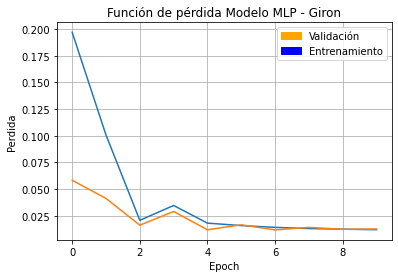

In [11]:
plt.figure(figsize=(6,4))
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo MLP - Giron')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.show()

In [12]:
y_pred = Giron_MLP_model_1.predict(X_test)
y_train_inv = dengue_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = dengue_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = dengue_transformer.inverse_transform(y_pred.reshape(1, -1))
print(y_train_inv.shape)
print(y_test_inv.shape)
print(y_pred_inv.shape)

4/4 [==============================] - 0s 3ms/step
(1, 247)
(1, 103)
(1, 103)


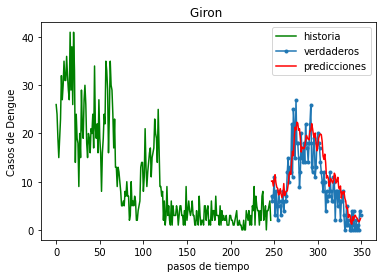

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="historia")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="verdaderos")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="predicciones")
plt.title('Giron ')
plt.ylabel('Casos de Dengue')
plt.xlabel('pasos de tiempo')
plt.legend()
plt.show();

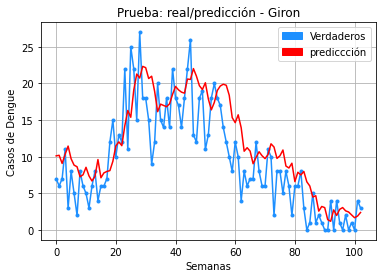

In [14]:
plt.title('Prueba: real/predicción - Giron' )
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.plot(y_test_inv.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv.flatten(), color= 'red', label="prediccción")
plt.grid(True)
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.show()

In [15]:
score = np.sqrt(metrics.mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("RMSE  Giron       : {}".format(score))
print("MSE Giron  = ", mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("MAE Giron = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print("r2_score Giron  = ", r2_score(y_test_inv.flatten(), y_pred_inv.flatten()))
print("explained_variance_score Giron  = ", explained_variance_score(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE  Giron       : 4.4502713362722375
MSE Giron  =  19.804914966446283
MAE Giron =  3.574529844580345
r2_score Giron  =  0.5566918244598098
explained_variance_score Giron  =  0.6654602147981261


In [16]:
# VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

resultados = pd.DataFrame({ 'Actuales':y_test_inv.flatten(), 'Predicciones': y_pred_inv.flatten()})
resultados['diferencia'] = resultados['Predicciones'] - resultados['Actuales']
resultados.head(60)

,Actuales,Predicciones,diferencia
0,7.0,10.114074,3.114074
1,6.0,10.194182,4.194182
2,7.0,9.080317,2.080317
3,11.0,10.325421,-0.674579
4,3.0,11.451437,8.451437
5,8.0,9.724370,1.724370
6,5.0,8.849067,3.849067
7,2.0,8.627103,6.627103
8,8.0,7.261086,-0.738914
9,6.0,7.529286,1.529286


In [17]:
resultados.tail(60)

,Actuales,Predicciones,diferencia
43,18.0,18.678160,0.678160
44,22.0,20.607143,-1.392857
45,26.0,20.553011,-5.446989
46,13.0,22.035492,9.035492
47,12.0,21.010757,9.010757
48,18.0,19.699219,1.699219
49,19.0,19.176126,0.176126
50,11.0,20.102617,9.102617
51,13.0,17.878441,4.878441
52,18.0,16.400064,-1.599936
